### Detect Subduction Initiation/Death

- The purpose of this notebook is to automatically detect the appearance of new subduction zones, and disappearance of existing ones, within a topological plate model
- The method compares subduction configurations against the configuration at the previous or next time snapshot, then examines the distance between each vertex along the subduction boundary at time t with the configuration at time t=t+dt or t=t-dt.
- The distance is unlikely to be zero between timesteps, even where subduction persists, due to trench migration. So we must set a distance threshold to distinguish between changes in the configuration that reflect trench migration (small distance) and changes that reflect addition or removal of an entire segment.
- This does not work perfectly. In many cases, the subduction line geometries change between time steps for reasons that are ambiguous (but in many cases probably not becuase the model is intended to imply actual wholesale changes in the plate boundary??). The code distinguishes between place where the subduction zone moves a lot but the plate pair across the boundary remains the same, as opposed to places where the plate pair changes (hence more likely to be a genuine change in plate boundary configuration?)
- Various lines also included for handling of bad topological segments (for these segements, plate pair cannot be determined but still used for distance check).
- Also added code to detect distance to nearest continental polygon at time of initiation/death

In [3]:
import pygplates
import numpy as np
from mpl_toolkits.basemap import Basemap
from topology_plotting import *
from matplotlib.patches import Polygon
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Specify some input files

#rotation_filename = '/Users/Simon/GIT/pygplates-alpha/tutorials-sv/Data/Seton_etal_ESR2012_2012.1.rot'
#input_topology_filename = '../tutorials-sv/Data/Seton_etal_ESR2012_PP_2012.1.gpmlz'
#topology_features = pygplates.FeatureCollection(input_topology_filename)

rotation_filename = './Data/Global_EarthByte_230-0Ma_GK07_AREPS.rot'
GPML_List = ['./Data/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpmlz',\
                          './Data/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpmlz']


topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)

# Static polygons to determine whether subduction segment is adjacent to continent or not
static_polygon_filename = './Data/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v15.gpmlz'
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
continental_polygon_features = []
for feature in static_polygon_features:
    if feature.get_feature_type() == pygplates.FeatureType.gpml_closed_continental_boundary:
        continental_polygon_features.append(feature)

pygplates.FeatureCollection(continental_polygon_features).write('continental_polygons.gpmlz')
        
# End of input specification

###########################################################
rotation_model = pygplates.RotationModel(rotation_filename)


# Function to detect the 

def subduction_continuity(topology_features,rotation_model,time,time_offset,continental_polygon_features):
    
    resolved_topologies = []
    shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, resolved_topologies, time, shared_boundary_sections)

    prev_resolved_topologies = []
    prev_shared_boundary_sections = []
    pygplates.resolve_topologies(topology_features, rotation_model, prev_resolved_topologies, time+time_offset, prev_shared_boundary_sections)


    prev_subduction_geometries = []
    prev_subduction_plate_pair = []
    for shared_boundary_section in prev_shared_boundary_sections:
        # Skip sections that are not ridges or subduction zones.
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                prev_subduction_geometries.append(shared_sub_segment.get_geometry())
                if len(shared_sub_segment.get_sharing_resolved_topologies())==2:
                    plate_pair = [shared_sub_segment.get_sharing_resolved_topologies()[0].get_feature().get_reconstruction_plate_id(),
                                 shared_sub_segment.get_sharing_resolved_topologies()[1].get_feature().get_reconstruction_plate_id()]
                    prev_subduction_plate_pair.append(np.sort(plate_pair))
                else:
                    prev_subduction_plate_pair.append(np.array((0,0)))
                    
    reconstructed_continental_polygons = []
    pygplates.reconstruct(continental_polygon_features,
                          rotation_model,
                          reconstructed_continental_polygons,
                          time,
                          anchor_plate_id=0)
                

    result = []

    dist = []     # distance to nearest point on the next/previous subduction network
    szLon = []
    szLat = []
    dist2cont = []   # distance to nearest continental polygon
    time_list = []
    bad_segment_length = 0

    for shared_boundary_section in shared_boundary_sections:

        # Skip sections that are not ridges or subduction zones.
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.create_gpml('SubductionZone'):
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                
                # Detect the plate pair - but, if the segment is a 'bad' segment, we still need
                # to consider it, since this would otherwise cause us to detect false initiations
                # and deaths. Bad segments are assigned a plate_pair that will always be different 
                # from subduction zones in other 
                if len(shared_sub_segment.get_sharing_resolved_topologies())==2:
                    plate_pair = [shared_sub_segment.get_sharing_resolved_topologies()[0].get_feature().get_reconstruction_plate_id(),
                                 shared_sub_segment.get_sharing_resolved_topologies()[1].get_feature().get_reconstruction_plate_id()]
                else:
                    plate_pair = np.array((-1,-1))
                    bad_segment_length += shared_sub_segment.get_geometry().get_arc_length()*pygplates.Earth.mean_radius_in_kms
                    #print 'skipping bad topological segment....'

                # resample segment to a more even distribution of points
                tesselated_segment = shared_sub_segment.get_geometry().to_tessellated(np.radians(0.5))
                #for segment in shared_sub_segment.get_resolved_geometry().get_segments():
                for point in tesselated_segment:
                    #point = segment.get_arc_point(0.5)
                    min_distance_to_all_features = None

                    for (prev_sz,prev_pp) in zip(prev_subduction_geometries,prev_subduction_plate_pair):
                        min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                            point,
                            prev_sz,
                            min_distance_to_all_features)

                        # If the current geometry is nearer than all previous geometries then
                        # its associated feature is the nearest feature so far.
                        if min_distance_to_feature is not None:
                            min_distance_to_all_features = min_distance_to_feature
                            closest_pp = prev_pp

                    if not np.array_equal(np.sort(closest_pp),np.sort(plate_pair)):
                        min_distance_to_all_features = min_distance_to_all_features*-1.

                    d2c = get_nearest_continental_polygon(point,reconstructed_continental_polygons)

                    #print dist
                    if min_distance_to_all_features is not None:
                        dist.append(min_distance_to_all_features*pygplates.Earth.mean_radius_in_kms)
                        szLon.append(point.to_lat_lon()[1])
                        szLat.append(point.to_lat_lon()[0])
                        dist2cont.append(d2c)
                        time_list.append(time)
                    
    print('done time %0.2fMa, total bad segment length = %0.2f' % (time,bad_segment_length))

    return szLon,szLat,dist,dist2cont,time_list


# Function to get distance to nearest continental polygon (should be reconstructed already)
def get_nearest_continental_polygon(seed_point,continental_polygons):
    
    min_distance_to_all_features = np.radians(180)
    nearest_continent = None        

    for polygon in continental_polygons:
        if polygon is not None:
            min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                polygon.get_reconstructed_geometry(),
                seed_point,
                min_distance_to_all_features,
                geometry1_is_solid=True)

            # If the current geometry is nearer than all previous geometries then
            # its associated feature is the nearest feature so far.
            if min_distance_to_feature is not None:
                min_distance_to_all_features = min_distance_to_feature
                nearest_continent = polygon.get_feature().get_reconstruction_plate_id()
                    
    return min_distance_to_all_features*pygplates.Earth.mean_radius_in_kms



In [6]:
# Run subduction initiation

# Time range and time increment for convergence velocity calculation
time_step = 1.
time_offset = 1.
time_start = 0
time_end = 230.5

results_initiation = []

DataFrameTemplate = ('lon','lat','dist2sz','dist2cont','Age')
# Create an empty dataframe to concatenate results to
df_AllTimes = pd.DataFrame(columns=DataFrameTemplate)


for time in np.arange(time_start,time_end,time_step):

    szLon,szLat,dist,dist2cont,sAge = subduction_continuity(topology_features,rotation_model,time,time_offset,
                                                       continental_polygon_features)
    #results_initiation.append([szLon,szLat,dist,dist2cont,sAge])
    szdata=[]
    for item in zip(szLon,szLat,dist,dist2cont,sAge):
        szdata.append(item)
    df = pd.DataFrame(szdata, columns = DataFrameTemplate)
    
    df_AllTimes = df_AllTimes.append(df)
    
    subset = df[(df['dist2sz']<-200.)]
    # Plotting
    coastlines_file = './Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
    pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time)

    pygplates.reconstruct(continental_polygon_features, rotation_model, 'tmp2.shp', time)
    
    fig = plt.figure(figsize=(20,8),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0.5)
        plt.gca().add_patch(poly)
        
    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp2','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='grey',edgecolor='none',alpha=0.3,zorder=0.25)
        plt.gca().add_patch(poly)

    #plot_velocities_and_topologies(m,topology_features,rotation_model,time,
    #                               delta_time=1,res=3,scale=4000,lon0=lon0,clip_path=cp,alpha=0.2)

    x,y = m(np.array(df['lon']),np.array(df['lat']))
    l1 = m.plot(x,y,'.',color='gray',zorder=1,alpha=0.2)
    
    x,y = m(np.array(subset['lon']),np.array(subset['lat']))
    l1 = m.scatter(x,y,c=np.array(subset['dist2cont']),s=70, #np.array(subset['dist2cont']),
            edgecolors='',zorder=3,cmap=plt.cm.jet_r,vmin=0,vmax=2000)
    
    plt.title('Initiating Subduction Zones at %s Ma, coloured by distance to continent' % time, size=16)
    plt.colorbar(l1,extend='max',label='distance (km)')

    plt.savefig('./images/sub_init_%sMa.png' % time)
    plt.close()

    
df_AllTimes.to_csv('./subduction_initiation_230_0.csv')

    

done time 0.00Ma, total bad segment length = 1601.64
done time 1.00Ma, total bad segment length = 2316.90
done time 2.00Ma, total bad segment length = 928.86
done time 3.00Ma, total bad segment length = 2035.05
done time 4.00Ma, total bad segment length = 6908.73
done time 5.00Ma, total bad segment length = 2428.36
done time 6.00Ma, total bad segment length = 3940.86
done time 7.00Ma, total bad segment length = 2491.05
done time 8.00Ma, total bad segment length = 2554.24
done time 9.00Ma, total bad segment length = 2606.35
done time 10.00Ma, total bad segment length = 974.42
done time 11.00Ma, total bad segment length = 2494.60
done time 12.00Ma, total bad segment length = 2425.25
done time 13.00Ma, total bad segment length = 11248.70
done time 14.00Ma, total bad segment length = 776.66
done time 15.00Ma, total bad segment length = 2151.49
done time 16.00Ma, total bad segment length = 2736.90
done time 17.00Ma, total bad segment length = 3368.09
done time 18.00Ma, total bad segment len

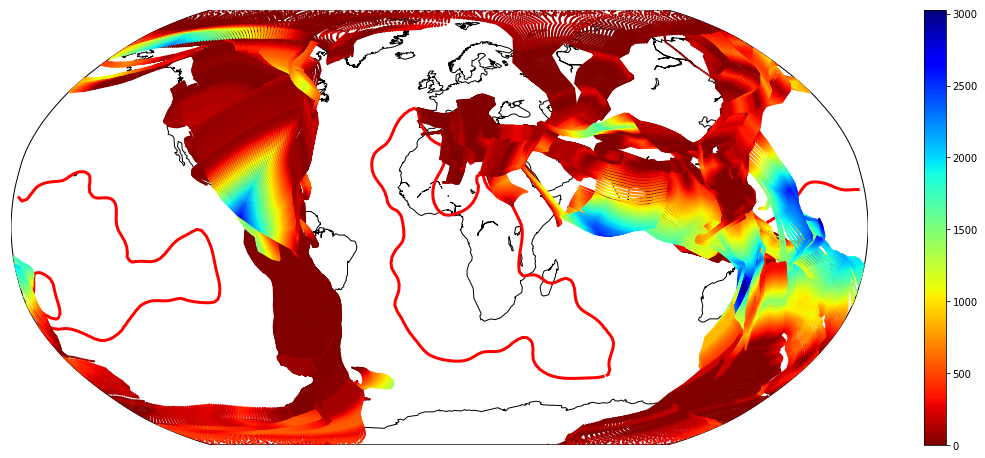

In [11]:
from mpl_toolkits.basemap import Basemap

LLSVP_edge_filename = '/Users/Simon/Data/SeismicTomography/SMEAN/SMEANSLOW1'

plt.figure(figsize=(20,8))

m = Basemap(projection='robin',lon_0=0)
m.drawcoastlines()
m.readshapefile(LLSVP_edge_filename,'tmp',color='r',linewidth=3,zorder=2)

x,y = m(np.array(df_AllTimes['lon']),np.array(df_AllTimes['lat']))
m.scatter(x,y,c=np.array(df_AllTimes['dist2cont']),
            s=5,edgecolors='',zorder=3,cmap=plt.cm.jet_r)
#x,y = m(np.array(df_mes['lon']),np.array(df_mes['lat']))
#m.plot(x,y,'.',color='gray',zorder=1,alpha=0.02)

#subset = df_AllTimes[(df_AllTimes['Age']>250.)]
#x,y = m(np.array(subset['lon']),np.array(subset['lat']))
#m.scatter(x,y,c=np.array(subset['Age']),
#            s=25,edgecolors='',zorder=3,cmap=plt.cm.jet_r,alpha=0.02)

plt.colorbar()
plt.show()

# Explanation
# The coloured lines are subduction initiation sites according to the logic of the code,
# coloured by age
# The grey transparent points are all subduction zones



In [13]:
# Run subduction initiation

# Time range and time increment for convergence velocity calculation
time_step = 1.
time_offset = -1.
time_start = 1.
time_end = 230.5

results_death = []

DataFrameTemplate = ('lon','lat','dist2sz','dist2cont','Age')
# Create an empty dataframe to concatenate results to
df_AllTimes_d = pd.DataFrame(columns=DataFrameTemplate)


for time in np.arange(time_start,time_end,time_step):

    szLon,szLat,dist,dist2cont,sAge = subduction_continuity(topology_features,rotation_model,time,time_offset,
                                                       continental_polygon_features)
    #results_initiation.append([szLon,szLat,dist,dist2cont,sAge])
    szdata=[]
    for item in zip(szLon,szLat,dist,dist2cont,sAge):
        szdata.append(item)
    df = pd.DataFrame(szdata, columns = DataFrameTemplate)
    
    df_AllTimes_d = df_AllTimes_d.append(df)
    
    subset = df[(df['dist2sz']<-200.)]
    # Plotting
    coastlines_file = './Data/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
    pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time)

    pygplates.reconstruct(continental_polygon_features, rotation_model, 'tmp2.shp', time)
    
    fig = plt.figure(figsize=(20,8),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='DarkKhaki',edgecolor='none',alpha=0.5,zorder=0.5)
        plt.gca().add_patch(poly)
        
    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp2','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='grey',edgecolor='none',alpha=0.3,zorder=0.25)
        plt.gca().add_patch(poly)

    #plot_velocities_and_topologies(m,topology_features,rotation_model,time,
    #                               delta_time=1,res=3,scale=4000,lon0=lon0,clip_path=cp,alpha=0.2)

    x,y = m(np.array(df['lon']),np.array(df['lat']))
    l1 = m.plot(x,y,'.',color='gray',zorder=1,alpha=0.2)
    
    x,y = m(np.array(subset['lon']),np.array(subset['lat']))
    l1 = m.scatter(x,y,c=np.array(subset['dist2cont']),s=70, #np.array(subset['dist2cont']),
            edgecolors='',zorder=3,cmap=plt.cm.jet_r,vmin=0,vmax=2000)
    
    plt.title('Dying Subduction Zones at %s Ma, coloured by distance to continent' % time, size=16)
    plt.colorbar(l1,extend='max',label='distance (km)')

    plt.savefig('./images/sub_death_%sMa.png' % time)
    plt.close()

    
    

done time 1.00Ma, total bad segment length = 2316.90
done time 2.00Ma, total bad segment length = 928.86
done time 3.00Ma, total bad segment length = 2035.05
done time 4.00Ma, total bad segment length = 6908.73
done time 5.00Ma, total bad segment length = 2428.36
done time 6.00Ma, total bad segment length = 3940.86
done time 7.00Ma, total bad segment length = 2491.05
done time 8.00Ma, total bad segment length = 2554.24
done time 9.00Ma, total bad segment length = 2606.35
done time 10.00Ma, total bad segment length = 974.42
done time 11.00Ma, total bad segment length = 2494.60
done time 12.00Ma, total bad segment length = 2425.25
done time 13.00Ma, total bad segment length = 11248.70
done time 14.00Ma, total bad segment length = 776.66
done time 15.00Ma, total bad segment length = 2151.49
done time 16.00Ma, total bad segment length = 2736.90
done time 17.00Ma, total bad segment length = 3368.09
done time 18.00Ma, total bad segment length = 3398.05
done time 19.00Ma, total bad segment le

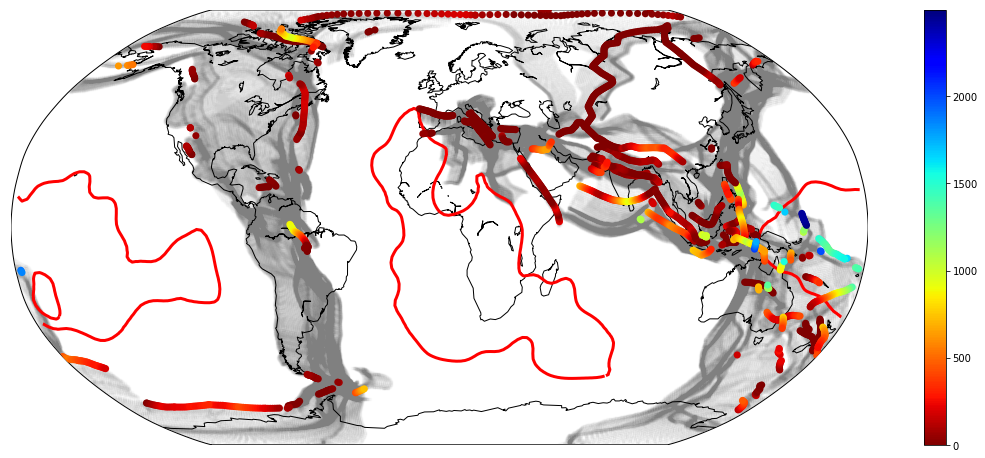

In [14]:
# subduction death

subset = df_AllTimes_d[(df_AllTimes_d['dist2sz']<-200.)]
subset_rec = df_AllTimes_d[(df_AllTimes_d['dist2sz']<-200.) & (df_AllTimes_d['Age']<=100.)]
subset_old = df_AllTimes_d[(df_AllTimes_d['dist2sz']<-200.) & (df_AllTimes_d['Age']>100.)]


plt.figure(figsize=(20,8))

m = Basemap(projection='robin',lon_0=0)
m.drawcoastlines()
m.readshapefile(LLSVP_edge_filename,'tmp',color='r',linewidth=3,zorder=2)

x,y = m(np.array(subset['lon']),np.array(subset['lat']))
m.scatter(x,y,c=np.array(subset['dist2cont']),
            s=50,edgecolors='',zorder=3,cmap=plt.cm.jet_r)
x,y = m(np.array(df_AllTimes_d['lon']),np.array(df_AllTimes_d['lat']))
m.plot(x,y,'.',color='gray',zorder=1,alpha=0.02)

plt.colorbar()
plt.show()

df_AllTimes_d.to_csv('./subduction_death_230_0.csv')

